# Image Compression for Stylized Images - Dimensionality Reduction

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io scikit-image


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
from sklearn.manifold import TSNE


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


#

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-08-12 08:28:32.825813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 08:28:32.905017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 08:28:32.905256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 08:28:32.905938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


In [5]:
root_dir = "result/stylized_compression"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)


## Load Training Data

#

In [6]:
def load_from_directory(data_dir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize, cache_name="stylizedAECache"):
        ds = ds.cache(filename='/tmp/{0}'.format(cache_name), name=cache_name)
        #ds = ds.cache()
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    data_train_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float16)
        lab = tfio.experimental.color.rgb_to_lab(image)

        return lab

    nrBatches = len(train_ds)

    # Translate [0,255] -> [-1, 1]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))
    #normalized_expected_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))

    # Combined train and expected data.
    normalized_train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds))

    final_normalized_train_ds = normalized_train_ds.take(int(train_size * nrBatches))

    offset_skip = int(train_size * nrBatches)
    validation_nr_batchs = int((1.0 - train_size) * nrBatches)
    normalized_test_ds = normalized_train_ds.skip(offset_skip).take(validation_nr_batchs)

    return configure_for_performance(final_normalized_train_ds, AUTOTUNE, 0, "stylizedAECacheTrain"), configure_for_performance(normalized_test_ds, AUTOTUNE, 0, "stylizedAECacheValidation")


In [7]:
BATCH_SIZE = 8
IMAGE_SIZE = (256, 256)
EPOCHS = 12

data_directory_path = "data-stylized-compression/"
data_dir = pathlib.Path(data_directory_path)

train_images, validation_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE, 0.9)

print("Train: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

print("Validation: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


Found 184438 files belonging to 1 classes.


2022-08-12 08:28:51.842286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 08:28:51.850955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 08:28:51.851140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 08:28:51.851256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Train: Number of batches 20749 of 8 elements
Validation: Number of batches 20749 of 8 elements


## Augment DataSet
By augmenting the image, it can reduce overfitting since no image will be the same between each epoch.

In [8]:
trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomRotation(0.5)
])


def func(x, y):
    aX = trainAug(x)
    return (aX, aX)


trainAugmentedDS = (
    train_images
    .map(func,
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


# Example Data

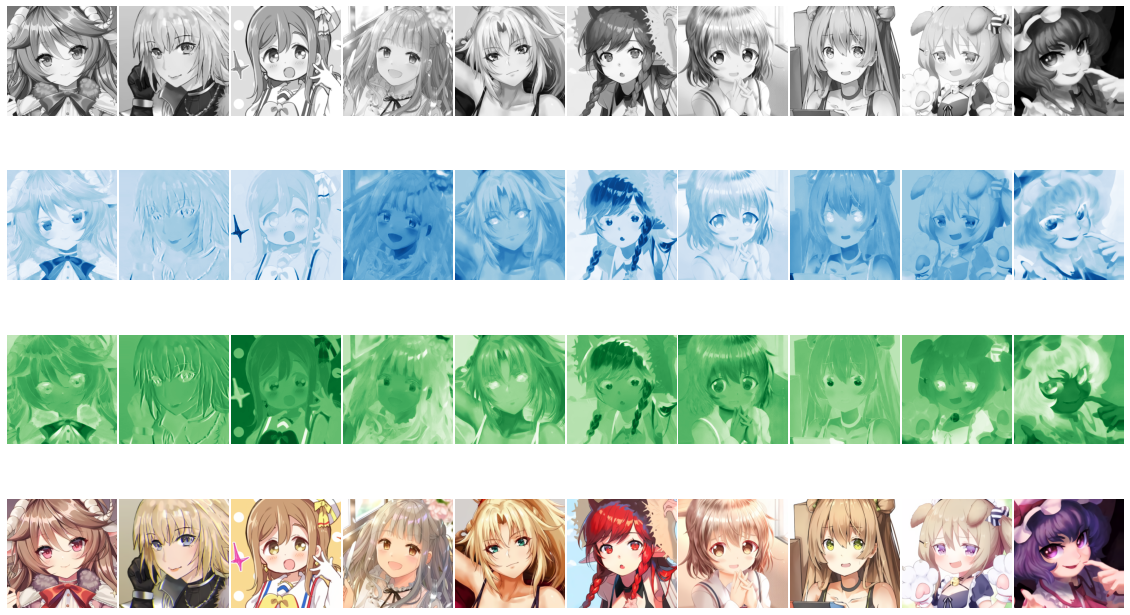

In [9]:
bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)


nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Augmented DataSet
Creates altered image to prevent overfitting

2022-08-12 08:28:58.237641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


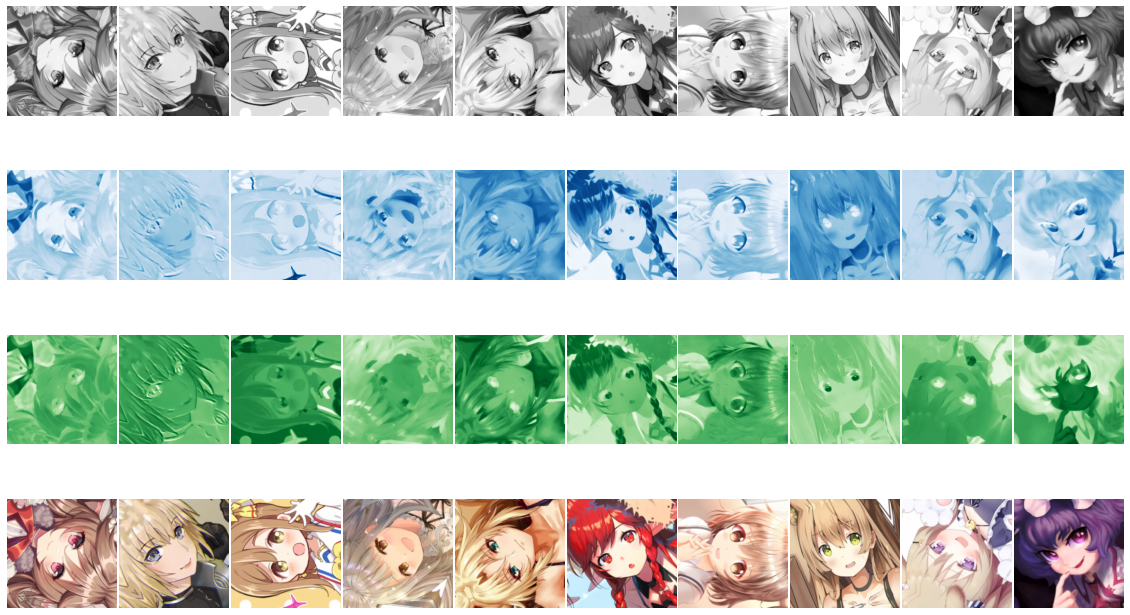

In [10]:
bathc_iter = iter(trainAugmentedDS)
image_batch, expected_batch = next(bathc_iter)

nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


# Create Model

In [11]:
def generate_cnn_builder(hp, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, image_size, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            activation_dict = {
                'leaky_relu': layers.LeakyReLU(alpha=0.2, dtype='float32'),
                'relu': layers.ReLU(dtype='float32')
            }

            batch_norm = hp.Boolean('batch_norm')
            use_upscale = False  # hp.Boolean('up_scale')

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'leaky_relu'])

            hp_kernel_filter_size_l1 = hp.Int('kernel_filter', min_value=7, max_value=7, step=1)
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
            num_downscale = hp.Int('num_downscale', min_value=1, max_value=2, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=3, max_value=4, step=1)

            regularization = hp.Int(
                'regularization', min_value=4, max_value=5, step=1)

            self.encoder = tf.keras.Sequential(name="Encoder")
            self.encoder.add(layers.Input(image_size))

            encoder_last_conv2 = None
            for i in range(0, number_layers):
                filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

                for j in range(0, num_downscale):
                    self.encoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                                   padding='same', strides=(2, 2), kernel_initializer=kernel_init))
                    self.encoder.add(activation_dict[kernel_activation])
                    if batch_norm:
                        self.encoder.add(layers.BatchNormalization(dtype='float32'))

                encoder_last_conv2 = layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                                   strides=(1, 1), padding='same', kernel_initializer=kernel_init)
                self.encoder.add(encoder_last_conv2)
                self.encoder.add(activation_dict[kernel_activation])
                if batch_norm:
                    self.encoder.add(layers.BatchNormalization(dtype='float32'))

            # For adding sparse, for improve of thing with small variance.
            self.encoder.add(layers.ActivityRegularization(l1=10 ** -regularization, dtype='float32'))

            # Flatten to connect to forward neuron.
            self.encoder.add(layers.Flatten(name="latentspace"))

            # Create decoder.
            self.decoder = tf.keras.Sequential(name="Decoder")

            connect_conv_shape = encoder_last_conv2.output_shape

            self.decoder.add(layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3])))

            for i in range(0, number_layers):
                filter_size = 2 ** ((hp_kernel_filter_size_l1 - number_layers) + i + 1)

                self.decoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                 strides=(1, 1), padding='same', kernel_initializer=kernel_init))
                self.decoder.add(activation_dict[kernel_activation])
                if batch_norm:
                    self.decoder.add(layers.BatchNormalization(dtype='float32'))

                for _ in range(0, num_downscale):
                    if not use_upscale:
                        self.decoder.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=hp_kernel_size,
                                                                padding='same', strides=(2, 2), kernel_initializer=kernel_init))
                        self.decoder.add(activation_dict[kernel_activation])
                        if batch_norm:
                            self.decoder.add(layers.BatchNormalization(dtype='float32'))
                    else:
                        self.decoder.add(layers.UpSampling2D(size=(2, 2)))

            self.decoder.add(layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
            if batch_norm:
                self.decoder.add(layers.BatchNormalization(dtype='float32'))
            self.decoder.add(layers.Activation(activation='tanh', dtype='float32'))

        def compile(self, optimizer, **kwargs):
            super(Autoencoder, self).compile(**kwargs)
            self.optimizer = optimizer

    autoencoder = Autoencoder(hp, image_size)

    hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 2e-4, 5e-4])
    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    ae_input = layers.Input(shape=image_size, name="AE_input")
    ae_encoder_output = autoencoder.encoder(ae_input)
    ae_decoder_output = autoencoder.decoder(ae_encoder_output)

    conv_autoencoder = keras.Model(inputs=ae_input, outputs=ae_decoder_output)

    hp_loss = hp.Choice('loss', ['mse', 'binary_crossentropy'])

    conv_autoencoder.compile(optimizer=optimizer, loss=hp_loss, metrics=['accuracy'])

    return conv_autoencoder


## Hyperparameter

In [12]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage, verbose=0)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    batch_iter = iter(batchImage)
    image_batch, _ = next(batch_iter)

    fig = plt.figure(figsize=(maxNumImages * 2, 5 * 2))
    for i in range(nrElements):

        ax = plt.subplot(5, maxNumImages, i + 1)
        plt.imshow((asarray(lab2rgb(image_batch[i % len(image_batch)] * 128)).astype(dtype='float32')))
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 1 + i + 1)
        plt.imshow(output[i, :, :, 0], cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 2 + i + 1)
        plt.imshow(output[i, :, :, 1], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 3 + i + 1)
        plt.imshow(output[i, :, :, 2], cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 4 + 1 + i)
        plt.imshow(asarray(lab2rgb(output[i])).astype(dtype='float32'))
        plt.axis("off")

        if len(image_batch) - 1 == i:
            image_batch, _ = next(batch_iter)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData.take(12)
        self.dir_path = dir_path
        self.latent_space = latent_space
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("{0}/StylizedCompression{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))
        fig = showResult(self.model, self.trainSet, 14)
        fig.savefig("{0}/StylizedCompressionBig{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))


In [13]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print('Train Image Size: ' + str(image_shape))


def hyperparamter_model_builder(hp):
    model = generate_cnn_builder(hp, image_shape)
    return model

class SaveTrailImageResultCallback(tf.keras.callbacks.Callback):

    def __init__(self, tuner, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.tuner = tuner

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        state = self.tuner.get_state()
        fig = showResult(self.model, validation_images.take(2))
        index = 0
        if len(self.tuner.oracle.start_order) > 0:
            index = self.tuner.oracle.start_order[-1]
        fig.savefig(str.format('{0}/ImageAtEpoch{1}.png', self.tuner.get_trial_dir(index), epoch))


tuner = kt.Hyperband(hyperparamter_model_builder,
                     objective=[kt.Objective("'val_accuracy", direction="max")],
                     max_epochs=6,
                     factor=4,
                     directory=str.format('{0}/cache', root_dir),
                     project_name=str.format('Stylized AutoEncoder - {0}', "Compression"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)

tuner.search(trainAugmentedDS.take(3000), epochs=EPOCHS,
             validation_data=validation_images.take(50),
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN(), SaveTrailImageResultCallback(tuner)], verbose=1)


best_models = []
best_hps = tuner.get_best_hyperparameters(num_trials=8)

# Fetch all the best models and compare.
for hps in best_hps:
    model = tuner.hypermodel.build(hps)
    best_models.append(model)


Trial 8 Complete [01h 19m 11s]
multi_objective: 0.0

Best multi_objective So Far: 0.0
Total elapsed time: 02h 42m 57s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
False             |False             |batch_norm
lecun_uniform     |glorot_uniform    |kernel_initializer
relu              |relu              |kernel_activation
7                 |7                 |kernel_filter
4                 |5                 |kernel_size
1                 |2                 |num_downscale
3                 |3                 |number_layers
4                 |4                 |regularization
sgd               |rmsprop           |optimizer
0.0002            |0.0002            |learning_rate
mse               |binary_crossent...|loss
6                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/6


2022-08-12 11:11:59.172093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3000/3000 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9422

2022-08-12 11:14:01.939917: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-12 11:19:42.318346: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-12 11:19:42.555889: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

In [ ]:
model_results = []
latent_spaces = []

EPOCHS = 24

for ae_model in best_models:

    latent_space = ae_model.get_layer("Encoder").get_layer("latentspace").output_shape[1]
    latent_spaces.append(latent_space)

    checkpoint_path = str.format("result/stylized_compression/checkpoints/cp_{0}.ckpt", latent_space)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=ae_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        ae_model.load_weights(checkpoint_path)

    autoencoder_history = ae_model.fit(trainAugmentedDS.take(1000),
                                       epochs=EPOCHS,
                                       shuffle=True, callbacks=[cp_callback, save_images(str.format("result/stylized_compression/stylized_compression_latent_{0}", latent_space), latent_space, train_images)])

    ae_model.save_weights(checkpoint_path)


## Saving Model

In [ ]:
for ae_model in best_models:
    ae_model.save("result/stylized_compression/stylized-ae-compression.h5")

    ae_model.layers[1].save("result/stylized_compression/stylized-encoder.h5")
    ae_model.layers[2].save("result/stylized_compression/stylized-decoder.h5")
    encoder = ae_model.layers[1]
    decoder = ae_model.layers[2]


## Result
The result is both in how good the model reconstruct as well how much of a compression ratio it would yield.

In [ ]:
# Compute evolution
for ae_model in best_models:
    latent_space_size = ae_model.layers[1].output_shape[1]
    print("Latent Space ", latent_space_size)

    result = ae_model.evaluate(validation_images, batch_size=BATCH_SIZE, verbose=0)
    print("loss, accuracy ", result)


Latent Space  16


2022-08-05 01:29:47.916093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-05 01:44:08.686523: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


loss, accuracy  [0.02514222264289856, 0.9385086297988892]
Latent Space  16
loss, accuracy  [0.042462099343538284, 0.9161767363548279]
Latent Space  16
loss, accuracy  [0.3058066666126251, 0.9384972453117371]
Latent Space  4096
loss, accuracy  [0.20533522963523865, 0.9396572113037109]
Latent Space  16
loss, accuracy  [0.3735292851924896, 0.9385086297988892]
Latent Space  4096
loss, accuracy  [0.017375117167830467, 0.9477706551551819]


In [ ]:

def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10), dpi=300)
    for i, (latent_space, result) in enumerate(zip(latent_spaces, results)):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', latent_space))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "Stylized Compression Performance History"))


<Figure size 0x3000 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
for ae_model in best_models:
    showResult(ae_model, train_images, 8)


## Plot Dimensional Reduction

In [ ]:
# Plot Result
fig = plt.figure(figsize=(len(best_models) * 10, 2 * 5), dpi=300)
for i, (lantent_space, model) in enumerate(zip(latent_spaces, best_models)):
    ax = plt.subplot(1, len(best_models), i + 1)
    encoder_model = model.layers[1]
    latent_value = encoder_model.predict(train_images, batch_size=256, verbose=0)

    if len(latent_value[0]) > 1:
        tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
        X_tsne = tsne.fit_transform(latent_value)
        ax.title.set_text(str.format('Latent Space {0}', lantent_space))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        plt.colorbar()
    else:
        plt.scatter(latent_value[:, 0], np.zeros(len(latent_value)))
        plt.colorbar()
plt.show(block=False)


## Compression Ratio
Since the purpose of dimmension reduction is for creating a lossy compression that hopefully has a lower size than either the jpg/png. In respect to the level lossy.

In [ ]:
# Compute evolution
for ae_model in best_models:
    latent_space_size = ae_model.layers[1].output_shape[1]

    raw_image_size_byte = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    latent_space_byte = latent_space_size * 4
    compression_ratio = float(raw_image_size_byte) / float(latent_space_byte)

    # Compute error.
    print("Compression Ratio", compression_ratio)


Compression Ratio 1.5


In [ ]:
for ae_model in best_models:
    validation_latent_spaces = []
    for batch in validation_images:
        train, expected = batch
        encoder_model = model.layers[1]
        latent_space = encoder_model.predict(train, verbose=0)
        validation_latent_spaces.append(latent_space)

    compressed_file_path = 'result/stylized_compression/latent_space.npy'
    validation_latent_spaces = np.asarray(validation_latent_spaces).flatten()
    np.save(compressed_file_path, validation_latent_spaces)

    raw_latent_space_size_byte = len(validation_latent_spaces) * 4
    compressed_latent_space_size_byte = os.path.getsize(compressed_file_path)
    compression_ratio = float(raw_latent_space_size_byte) / float(compressed_latent_space_size_byte)
    print("Raw Latent space", raw_latent_space_size_byte)
    print("Compressed Latent space", compressed_latent_space_size_byte)
    print("Compression Ratio", compression_ratio)


Raw Latent space 21756903424
Compressed Latent space 10878451840
Compression Ratio 1.9999999764672396


## Episode Improvement Transition

In [ ]:
anim_file = 'result/stylized_compression/stylized-compression.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('StylizedCompression*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


## Present LatentSpace

In [ ]:
import scipy
import moviepy.editor


In [ ]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [ ]:
def generate_transition(model, latent_space, grid_size):
    nr_elemenets = 4
    seeds = np.random.randint(10000, size=2)
    zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
          for s in seeds]

    all_latents = interpolate(zs, nr_elemenets)

    generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(grid_size[0] * 2, grid_size[1] * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(grid_size[0], grid_size[1], i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()


In [ ]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


In [ ]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 16

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    # Generate figure in respect new latent pace
    fig = generate_grid_image(autoencoder_model.layers[2], latents, (5, 5), (4, 4))

    # Convert figure to bitmap.
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('result/stylized_compression/autoencoder_stylized_compression_transition_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file autoencoder_stylized_compression_transition_grid_1802.gif with imageio.


In [ ]:
Image(url=gif_filepath)


In [ ]:
# Transition between two sets of images.


In [ ]:
for ae_model in best_models:
    ae_model.summary()
    ae_model.layers[1].summary()
    ae_model.layers[2].summary()
